# <center> Project 2: GPS, Solving Systems of Equations, Conditioning, and Nonlinear Least Squares.

### <center>Group 6: Yedidya Moise, Shenghan Yueh, Juju Ren

__Solve the “Reality Check 4” project that is presented in the textbook Numerical Analysis by Timothy
Sauer (3rd edition, pages 248 – 251). More specifically, solve activities 1,2,4,5,6 (activity 3 is not
necessary)__

# <a name="Contents">Table of Contents</a>
- [0 Import Libraries](#Section-0)
- [1 Activity 1 Multivariate Newton’s Method](#Section-1)
    - [1.1 Define the Multivariate Newton’s solver](#Section-11)
    - [1.2 Find the root with Multivariate Newton’s Method](#Section-12)
    - [1.3 Stopping criteria and accuracy ](#Section-13)
    - [1.4 Demonstrate the quadratic converge](#Section-14)

<p>

- [2 Solve the problem via the quadratic formula](#Section-2)
    - [2.1 Define the quadratic solver](#Section-21)
    - [2.2 Solve with quadratic formula](#Section-22)
    - [2.3 Define the physically correct one](#Section-23)
    - [2.4 The benefits of quadratic solver](#Section-24)

<p>

- [4 A test of the conditioning of the four unbunched GPS](#Section-4)
    - [4.1 Define the new parameters](#Section-41)
    - [4.2 Plot the new location of satellites](#Section-42)
    - [4.3 Solve with quadratic method](#Section-43)
    - [4.4 Error and condition number](#Section-44)

<p>

- [5 A test of the conditioning of the four bunched GPS](#Section-5)
    - [5.1 Define the new parameters](#Section-51)
    - [5.2 Plot the new location of satellites](#Section-52)
    - [5.3 Solve with quadratic method](#Section-53)
    - [5.4 Error and condition number](#Section-54)

<p>
    
- [6 Adding more satellites (Least square solution)](#Section-6)
    - [6.1 Define the Gauss–Newton solver](#Section-61)
    - [6.2 Define the new parameters](#Section-62)
    - [6.3 Plot the new location of satellites](#Section-63)
    - [6.4 Setting the perturbation of ti](#Section-64)
    - [6.5 Solve the problem with Gauss–Newton method](#Section-65) 
    - [6.6 The emf of all the combinations of delta ti](#Section-66)

<p>
    
- [7 References](#Section-7)
    
<p>

## <a name="Section-0">Import Libraries</a> [top](#Contents)

In [1]:
import numpy as np
import sympy as sym
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from datetime import timedelta
from scipy.misc import derivative
import seaborn as sns
from itertools import combinations
from itertools import permutations 

In [2]:
np.set_printoptions(suppress=False)
np.set_printoptions(precision=16)

# <a name="Section-1">Activity 1 Multivariate Newton’s Method</a> [top](#Contents)  


## <a name="Section-11">Define the Multivariate Newton’s solver</a> [top](#Contents)  

__make sure that your implementation of Multivariate Newton’s Method does not compute the inverse of the Jacobian matri__
* step 1 Find the receiver position (x, y, z) near earth and time correction d for known, simultaneous satellite positions (in km):  
(15600km, 7540km, 20140km, 0.07074s),  
(18760km, 2750km, 18610km, 0.07220s),  
(17610km, 14630km, 13480km, 0.07690s),  
(19170km, 610km, 18390km, 0.07242s)  

In [3]:
def solve_with_QR(A,b):
    Q, R= np.linalg.qr(A)
    d=np.dot(Q.T,b)
    root=np.linalg.solve(R,d)
    norm_e=np.linalg.norm(np.dot(A,root)-b)
    return root, norm_e

In [4]:
def Jacobian(sat_positions, t_intervals, var):
    '''
    Input: the positions of satellites (Ai, Bi, Ci), ti, xi 
    Output: DF(x), F(x)
    '''
    x, y, z, d = var
    J = np.zeros((len(sat_positions),len(var)), dtype = float)
    r = np.zeros(len(sat_positions), dtype = float)
    for i in range(len(sat_positions)):
        r[i]=math.sqrt((x - sat_positions[i][0])**2 + (y-sat_positions[i][1])**2 + (z-sat_positions[i][2])**2) - (c*(t_intervals[i] - d))
        J[i][0] = (x-sat_positions[i][0])/math.sqrt((x - sat_positions[i][0])**2 + (y-sat_positions[i][1])**2 + (z-sat_positions[i][2])**2)
        J[i][1] = (y-sat_positions[i][1])/math.sqrt((x - sat_positions[i][0])**2 + (y-sat_positions[i][1])**2 + (z-sat_positions[i][2])**2)
        J[i][2] = (z-sat_positions[i][2])/math.sqrt((x - sat_positions[i][0])**2 + (y-sat_positions[i][1])**2 + (z-sat_positions[i][2])**2)
        J[i][3] = c

    return J, r

In [5]:
# get Reciever Positions
def Reciever(sat_positions, t_intervals, initial_v, TOL): 
    '''
    The stopping criteria is based on 2-norm of F(x)
    '''
    ite=0
    e=np.inf
    error=[]
    inf_error=[]
    DF_all=[]
    F_all=[]
    v_i_all=[]
    v_i=initial_v
    while e > TOL:
        DF,F = Jacobian(sat_positions, t_intervals, v_i)
        DF_all.append(DF)
        F_all.append(F)
        # calculate with Multivariate Newton’s Method
        # Formula: X(i+1) = Xi- DF(Xi)^(-1)*F(Xi)
        v_i = v_i - solve_with_QR(DF,F)[0]
        v_i_all.append(v_i)
        ite+=1
        e = np.linalg.norm(F)
        error.append(e)
        inf_error.append(np.linalg.norm(F,np.inf))
        #print(ite,v_i,e)
    return v_i, inf_error, DF_all, F_all, v_i_all
        

## <a name="Section-12">Find the root with Multivariate Newton’s Method</a> [top](#Contents)  

In [6]:
A1, B1, C1 =(15600,7540,20140)
A2, B2, C2 =(18760,2750,18610)
A3, B3, C3 =(17610,14630,13480)
A4, B4, C4 =(19170,610,18390)
t1, t2, t3, t4=[0.07074,0.07220, 0.07690,0.07242]
initial_v=np.array([0,0,6370,0])
c = 299792.458

In [7]:
# define constant value satellites position and transmission time
Position = np.array([[A1, B1, C1], [A2, B2, C2], [A3, B3, C3], [A4, B4, C4]])
t_intervals = np.array([t1, t2, t3, t4])
# get Reciever Position with given constant value
v_i, inf_error, DF_all, F_all, v_i_all=Reciever(Position, t_intervals, initial_v, 1e-16)
print('(x,y,z,d)=', v_i)

(x,y,z,d)= [-4.1772709570857543e+01 -1.6789194106537199e+01  6.3700595592233294e+03
 -3.2015658295942305e-03]


As a check, the answers are approximately
(x, y,z) = (−41.77271,−16.78919,6370.0596), and d = −3.201566 × 10−3 seconds
the result matches with the checking answer.

## <a name="Section-13">Stopping criteria and accuracy</a> [top](#Contents)  
__What stopping condition did you use in your solver? How accurate is the obtained solution
(root)?__


* In this question, we have F(x) =&emsp;
$\begin{bmatrix}
\sqrt{(x - A1)^2 + (y-B1)^2 + (z-C1)^2} - (c\times(t1 - d)) \\
\sqrt{(x - A2)^2 + (y-B2)^2 + (z-C2)^2} - (c\times(t2 - d))  \\
\sqrt{(x - A3)^2 + (y-B3)^2 + (z-C3)^2} - (c\times(t3 - d))  \\
\sqrt{(x - A4)^2 + (y-B4)^2 + (z-C4)^2} - (c\times(t4 - d)) 
\end{bmatrix} $, the root $v=[x, y, z, d]$ is where $F(v)=0$. 

Therefore, we used backward error $|F(v)|_2$ < TOL as the stoping condition.

* The backward error $|𝐹(𝑣)|_2$ < $10^{-16}$ 

## <a name="Section-14">Demonstrate the quadratic converge</a> [top](#Contents)  
__It can be shown that if at a neighborhood of an isolated root $x^∗$ the Jacobian matrix DF(x) has a bounded inverse and continuous derivatives, then Newton’s method converges locally quadratically. Demonstrate the quadratic converge of Multivariate Newton's Method by tabulating $|F(x_k)|_∞$
for k = 0, 1, 2,......__

In [8]:
DF_norm=[]
for i in DF_all:
    DF_norm.append(np.linalg.norm(i,np.inf))

In [9]:
ei=[] # norm(x*-xi)
x, y, z, d=[],[],[],[]
for i in v_i_all:
    ei.append(np.linalg.norm(v_i-i))
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])
    d.append(i[3])    

In [10]:
pd.DataFrame(list(zip(x,y,z,d, inf_error, ei)),
            columns =['x', 'y', 'z', 'd', '║F(xᵢ)║∞', 'ei'])

,x,y,z,d,║F(xᵢ)║∞,ei
0,-41.705646,-16.762293,6370.055589,-0.003201,9.246606e+02,7.236646e-02
1,-41.772709,-16.789194,6370.059559,-0.003202,1.782459e-02,1.806108e-07
2,-41.772710,-16.789194,6370.059559,-0.003202,5.228503e-08,1.470941e-10
3,-41.772710,-16.789194,6370.059559,-0.003202,3.637979e-12,3.979394e-11
4,-41.772710,-16.789194,6370.059559,-0.003202,3.637979e-12,0.000000e+00
5,-41.772710,-16.789194,6370.059559,-0.003202,0.000000e+00,0.000000e+00


Text(0, 0.5, '║F(xᵢ)║∞')

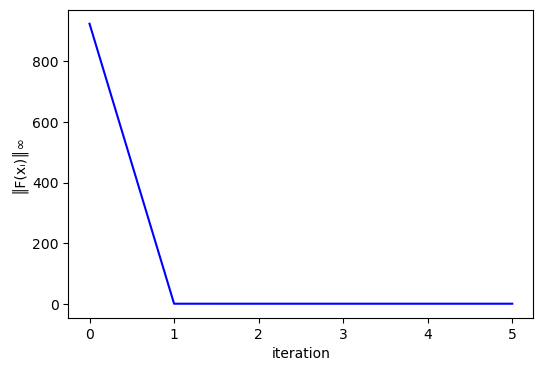

In [11]:
plt.figure(figsize=(6,4))

plt.plot(inf_error, 'b',1)
plt.xlabel('iteration')
plt.ylabel('║F(xᵢ)║∞')


# <a name="Section-2">Activity 2  Solve the problem via the quadratic formula</a> [top](#Contents)  

__By subtracting the last three equations of (4.38) from the first, we had the matrix A to hold the coefficients. The x, y, and z were substituted by d, which the coefficient was calculated by the rref function. We utilized the first equation of (4.38) to solve d.__

## <a name="Section-21">Define the quadratic solver</a> [top](#Contents)  

In [12]:
def d_solve_quadratic():
    A=np.array([[2*(A2-A1),2*(B2-B1),2*(C2-C1),2*(t1-t2)*c**2,A2**2-A1**2+B2**2-B1**2+C2**2-C1**2+(t1**2-t2**2)*c**2],
           [2*(A3-A1),2*(B3-B1),2*(C3-C1),2*(t1-t3)*c**2,A3**2-A1**2+B3**2-B1**2+C3**2-C1**2+(t1**2-t3**2)*c**2],
           [2*(A4-A1),2*(B4-B1),2*(C4-C1),2*(t1-t4)*c**2,A4**2-A1**2+B4**2-B1**2+C4**2-C1**2+(t1**2-t4**2)*c**2]],dtype=float)
    rref=sym.Matrix(A).rref()
    #print(rref[0])
    r14,r24,r34=rref[0][:,3]
    r15,r25,r35=rref[0][:,4]
    ac= float(r14**2+r24**2+r34**2-c**2)
    bc= float(-2*(r15-A1)*r14-2*(r25-B1)*r24-2*(r35-C1)*r34+2*c**2*t1)
    cc= float((r15-A1)**2+(r25-B1)**2+(r35-C1)**2-c**2*t1**2)
    
    d1=float((-bc+(bc**2-4*ac*cc)**0.5)/(2*ac))
    d2=float((-bc-(bc**2-4*ac*cc)**0.5)/(2*ac))

    
    return d1,d2,r14,r24,r34,[r15,r25,r35]

def quadratic(d):
    
    x=-r14*d+b[0]
    y=-r24*d+b[1]
    z=-r34*d+b[2]
    res=(x-A1)**2+(y-B1)**2+(z-C1)**2-(c*(t1-d))**2
    return res,x,y,z

def F(x,y,z,d):
    res=np.array([[(x-A1)**2+(y-B1)**2+(z-C1)**2-(c*(t1-d))**2],[(x-A2)**2+(y-B2)**2+(z-C2)**2-(c*(t2-d))**2],[(x-A3)**2+(y-B3)**2+(z-C3)**2-(c*(t3-d))**2],[(x-A4)**2+(y-B4)**2+(z-C4)**2-(c*(t4-d))**2]],dtype=float)
    return res

## <a name="Section-22">Solve with quadratic formula</a> [top](#Contents)  

__Plot the quadratic function. The roots for d are where quadratic(d) equals 0.__

Text(0, 0.5, 'quadratic(d)')

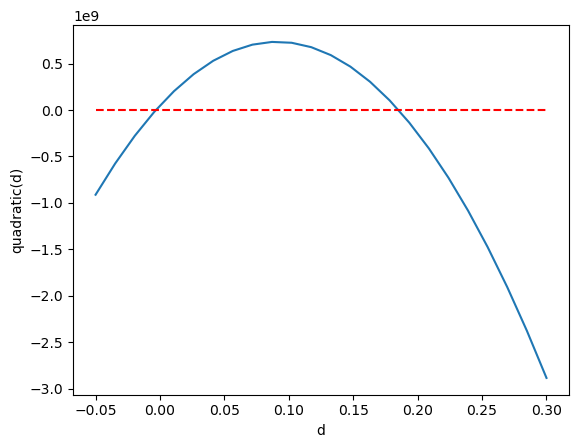

In [13]:
d=np.linspace(-0.05,0.3,24)
r14,r24,r34,b=d_solve_quadratic()[2:]
q_d=quadratic(d)[0]
zero = [0.0 for x in d]
plt.plot(d, q_d)
plt.plot(d, zero, '--', color='red')
plt.xlabel('d')
plt.ylabel('quadratic(d)')

__The solution of the quadratic function.__

In [14]:
d_solve_quadratic()[:2]

(-0.003201565829594134, 0.18517304709594568)

__Show the results of the location and d.__

In [15]:
r14,r24,r34,b=d_solve_quadratic()[2:]

In [16]:
d1=d_solve_quadratic()[0]
x1,y1,z1=quadratic(d1)[1:]
d2=d_solve_quadratic()[1]
x2,y2,z2=quadratic(d2)[1:]
print(f'(x1,y1,z1,d1)={(x1,y1,z1,d1)}')
print(f'(x2,y2,z2,d2)={(x2,y2,z2,d2)}')

(x1,y1,z1,d1)=(-41.7727095708333, -16.7891941065247, 6370.05955922334, -0.003201565829594134)
(x2,y2,z2,d2)=(-39.7478373481531, -134.274144360665, -9413.62455373576, 0.18517304709594568)


In [17]:
#Check the backward error
np.linalg.norm(F(x1,y1,z1,d1))

1.5769906706002895e-07

In [18]:
#Check the backward error
np.linalg.norm(F(x2,y2,z2,d2))

7.996802249550068e-07

## <a name="Section-23">Define the physically correct one</a> [top](#Contents)  
__How many solutions are there to system (4.37)? How did you choose the physically correct one
among them?__

There are two solutions in system 4.37. Since the origin is the center of the earth, the physically correct one is that the norm of the vector [x, y, z] is equal to the radius of the earth, around 6370 km. Therefore, the second solution is not correct. The location of the second solution is above the surface of the earth.

In [19]:
print(np.linalg.norm(np.array([x1,y1,z1],dtype=float)))
print(np.linalg.norm(np.array([x2,y2,z2],dtype=float)))

6370.218648080798
9414.666041613711


## <a name="Section-24">The benefits of quadratic solver</a> [top](#Contents)  
__Why is it better to solve system (4.37) using the quadratic formula instead of the Multivariate Newton Method?__

* The multivariate Newton Method uses derivatives during the process and is usually expensive to compute. In the quadratic formula, there is only one variable in a single equation. We can directly solve the equation.
* The multivariate Newton Method might diverge. On the other hand, the quadratic formula solves the root directly.
* The multivariate Newton Method needs an initial vector, which influences the result.

# <a name="Section-4">Activity 4 A test of the conditioning of the four unbunched GPS</a> [top](#Contents)  

## <a name="Section-41">Define the new parameters</a> [top](#Contents)  

__Set new parameters.__

In [20]:
p=26570
x,y,z,d= (0, 0, 6370, 0.0001)
phis=[i*math.pi/8 for i in range(1,5)]
thetas=[(i-1)*math.pi/2 for i in range(1,5)]


def range_R_t(phi,theta):
    Ai = float(p*math.cos(phi)*math.cos(theta))
    Bi = float(p*math.cos(phi)*math.sin(theta))
    Ci = float(p*math.sin(phi))
    Ri = float(math.sqrt(Ai**2+Bi**2+(Ci-6370)**2))
    ti = float(d + (Ri /c))
    return [Ai,Bi,Ci],ti

In [21]:
Ri=[] # Rename Ri
ti=[]
for phi, theta in zip(phis, thetas):
    res=range_R_t(phi,theta)
    Ri.append(res[0])
    ti.append(res[1])

__New locations for satellites.__

In [22]:
Ri

[[24547.479178824888, 0.0, 10167.898797940436],
 [1.150422620708853e-12, 18787.827176126568, 18787.827176126568],
 [-10167.898797940437, 1.2452084716951976e-12, 24547.479178824888],
 [-2.988646306899417e-28, -1.6269432726672588e-12, 26570.0]]

__New transmission time.__

In [23]:
ti

[0.08295578832300889,
 0.07522118789913924,
 0.06957483634975017,
 0.06747994723002672]

## <a name="Section-42">Plot the new location of satellites</a> [top](#Contents)  

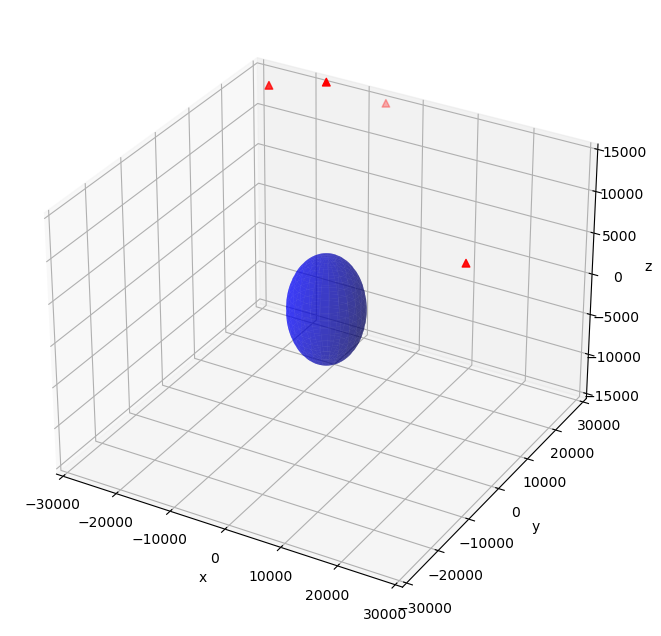

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_c = 6370 * np.outer(np.cos(u), np.sin(v))
y_c = 6370 * np.outer(np.sin(u), np.sin(v))
z_c = 6370 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_c, y_c, z_c, rstride=4, cstride=4, color='b',alpha=0.5)

# Plot the satellites
xs=[Ri[i][0] for i in range(4)]
ys=[Ri[i][1] for i in range(4)]
zs=[Ri[i][2] for i in range(4)]
ax.scatter3D(xs,ys,zs,c='r',marker='^',s=30)

ax.set_xlim3d(-30000, 30000)
ax.set_ylim3d(-30000,30000)
ax.set_zlim3d(-15000, 15000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

__The satellites evenly dispersed above the earth.__

## <a name="Section-43">Solve with quadratic method</a> [top](#Contents)  

__Generate time deviation.__

In [25]:
e=1e-8
deltati=[[e,e,e,-e],[e,e,-e,-e],[e,-e,e,-e],[e,-e,-e,-e]]

In [26]:
deltati

[[1e-08, 1e-08, 1e-08, -1e-08],
 [1e-08, 1e-08, -1e-08, -1e-08],
 [1e-08, -1e-08, 1e-08, -1e-08],
 [1e-08, -1e-08, -1e-08, -1e-08]]

In [27]:
# Define the parameters
A1, B1, C1 = Ri[0]
A2, B2, C2 = Ri[1]
A3, B3, C3 = Ri[2]
A4, B4, C4 = Ri[3]
#t1, t2, t3, t4 = ti

# find the location based on the new parameters
locationwithd=[]
for i in range(len(deltati)):
    #Define the parameter t
    t1, t2, t3, t4= ti[0]+deltati[i][0],ti[1]+deltati[i][1],ti[2]+deltati[i][2],ti[3]+deltati[i][3]
    #print(deltati[i][0],deltati[i][1],deltati[i][2],deltati[i][3])
    d1,d2,r14,r24,r34,b=d_solve_quadratic()
    x1,y1,z1=quadratic(d1)[1:]
    x2,y2,z2=quadratic(d2)[1:]
    norm_1=np.linalg.norm(np.array([x1,y1,z1],dtype=float))
    norm_2=np.linalg.norm(np.array([x2,y2,z2],dtype=float))
    #locationwithd.append([x1,y1,z1,d1])
    #locationwithd.append([x2,y2,z2,d2])
       
    if norm_1 <= 6370+10 and norm_1 >= 6370-10:
        print('[x,y,z,d]=',[x1,y1,z1,d1])
        locationwithd.append([x1,y1,z1,d1]) 
        print()
        print('backward error:')
        print(np.linalg.norm(F(x1,y1,z1,d1)))
        print()
    if norm_2 <= 6370+10 and norm_2 >= 6370-10:
        print('[x,y,z,d]=',[x2,y2,z2,d2])
        locationwithd.append([x2,y2,z2,d2])
        print()
        print('backward error:')
        print(np.linalg.norm(F(x2,y2,z2,d2)))
        print()

[x,y,z,d]= [0.00800303974309244, 0.00163956589250000, 6370.01641452326, 0.00010004475295049493]

backward error:
1.884864366154897e-07

[x,y,z,d]= [-0.00141483300802361, -0.00426858230279983, 6370.00542750150, 0.00010000810419457843]

backward error:
2.3084779657169682e-07

[x,y,z,d]= [0.00800303974921268, 0.00882672124634283, 6370.01641452368, 0.00010004475294567973]

backward error:
3.9085379387748244e-07

[x,y,z,d]= [-0.00141483300881406, 0.00291857656356070, 6370.00542750144, 0.0001000081041952004]

backward error:
1.884864366154897e-07



## <a name="Section-44">Error and condition number</a> [top](#Contents)  

In [28]:
# deviation from the original location
deviation=np.array(locationwithd)-np.array([0,0,6370,0.0001])
deviation

array([[0.00800303974309244, 0.00163956589250000, 0.0164145232611190,
        4.475295049492366e-08],
       [-0.00141483300802361, -0.00426858230279983, 0.00542750149543281,
        8.104194578424976e-09],
       [0.00800303974921268, 0.00882672124634283, 0.0164145236785771,
        4.4752945679724316e-08],
       [-0.00141483300881406, 0.00291857656356070, 0.00542750144177262,
        8.104195200391105e-09]], dtype=object)

__The maximum position error in meters__

In [29]:
p_o=[np.linalg.norm(np.array(i[:-1],dtype=float))*1000 for i in deviation]
print(f'the max. position error in meters: {max(p_o)}')

the max. position error in meters: 20.282905136658467


__Define the condition number.__

In [30]:
# condition number
def condition_number(deviation,deltati):
    emf=[]
    for i in range(len(deviation)):
        #print(deviation[i,:])
        infn_location=np.linalg.norm(deviation[i,:-1], np.inf)
        inf_time=np.linalg.norm(deltati[i], np.inf)
        emf.append(infn_location/(c*inf_time))
    return max(emf),emf

In [31]:
# all the emf
condition_number(deviation,deltati)[1]

[5.47529559970419, 1.81041962551066, 5.47529573895321, 1.81041960761155]

__The condition number of the location and transfer time with deviations.__ 

In [32]:
condition_number(deviation,deltati)[0]

5.47529573895321

__The maximum emf is when delta ti is $(+\epsilon,-\epsilon,+\epsilon,-\epsilon)$.__

# <a name="Section-5">Activity 5 A test of the conditioning of the four bunched GPS</a> [top](#Contents)

## <a name="Section-51">Define the new parameters</a> [top](#Contents)  

In [33]:
phis=[math.pi/2+((i-1)*5/100*math.pi/2) for i in range(1,5)]
thetas=[(i-1)*5/100*2*math.pi for i in range(1,5)]

In [34]:
Ri=[]
ti=[]
for phi, theta in zip(phis, thetas):
    res=range_R_t(phi,theta)
    Ri.append(res[0])
    ti.append(res[1])

## <a name="Section-52">Plot the new location of satellites</a> [top](#Contents)  

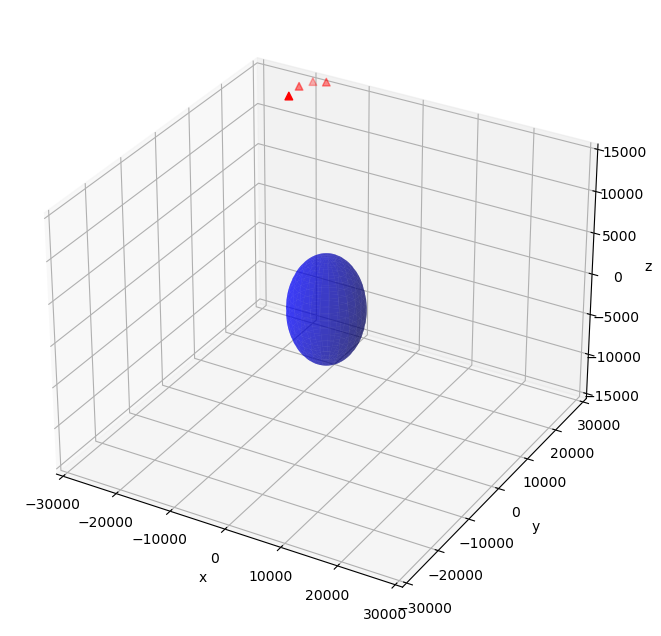

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_c = 6370 * np.outer(np.cos(u), np.sin(v))
y_c = 6370 * np.outer(np.sin(u), np.sin(v))
z_c = 6370 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_c, y_c, z_c, rstride=4, cstride=4, color='b',alpha=0.5)

# Plot the satellites
xs=[Ri[i][0] for i in range(4)]
ys=[Ri[i][1] for i in range(4)]
zs=[Ri[i][2] for i in range(4)]
ax.scatter3D(xs,ys,zs,c='r',marker='^',s=30)

ax.set_xlim3d(-30000, 30000)
ax.set_ylim3d(-30000,30000)
ax.set_zlim3d(-15000, 15000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

## <a name="Section-53">Solve with quadratic method</a> [top](#Contents)  

In [36]:
# Define the parameters
A1, B1, C1 = Ri[0]
A2, B2, C2 = Ri[1]
A3, B3, C3 = Ri[2]
A4, B4, C4 = Ri[3]

# find the location based on the new parameters
locationwithd=[]
for i in range(len(deltati)):
    #Define the parameter t
    t1, t2, t3, t4= ti[0]+deltati[i][0],ti[1]+deltati[i][1],ti[2]+deltati[i][2],ti[3]+deltati[i][3]
    #print(deltati[i][0],deltati[i][1],deltati[i][2],deltati[i][3])
    d1,d2,r14,r24,r34,b=d_solve_quadratic()
    x1,y1,z1=quadratic(d1)[1:]
    x2,y2,z2=quadratic(d2)[1:]
    norm_1=np.linalg.norm(np.array([x1,y1,z1],dtype=float))
    norm_2=np.linalg.norm(np.array([x2,y2,z2],dtype=float))
    #locationwithd.append([x1,y1,z1,d1])
    #locationwithd.append([x2,y2,z2,d2])
       
    if norm_1 <= 6370+10 and norm_1 >= 6370-10:
        print('[x,y,z,d]=',[x1,y1,z1,d1])
        locationwithd.append([x1,y1,z1,d1]) 
        print()
        print('backward error:')
        print(np.linalg.norm(F(x1,y1,z1,d1)))
        print()
    if norm_2 <= 6370+10 and norm_2 >= 6370-10:
        print('[x,y,z,d]=',[x2,y2,z2,d2])
        locationwithd.append([x2,y2,z2,d2])
        print()
        print('backward error::')
        print(np.linalg.norm(F(x2,y2,z2,d2)))
        print()

[x,y,z,d]= [-0.00986192514784520, 0.349281035186312, 6368.09269781885, 9.364791465689805e-05]

backward error:
2.5288109106536417e-07

[x,y,z,d]= [0.0472346296291460, -0.725930335614051, 6373.47192858088, 0.00011159106345512201]

backward error:
2.7314279645418166e-07

[x,y,z,d]= [-0.149615013831412, 1.53086584579278, 6362.47244684170, 7.490059014543343e-05]

backward error:
1.0323827311807139e-07

[x,y,z,d]= [-0.0924654835386317, 0.455042552033769, 6367.85464648507, 9.285385315879593e-05]

backward error:
2.5288109106536417e-07



## <a name="Section-54">Error and condition number</a> [top](#Contents)  

In [37]:
# deviation from the original location
deviation=np.array(locationwithd)-np.array([0,0,6370,0.0001])
deviation

array([[-0.00986192514784520, 0.349281035186312, -1.90730218115459,
        -6.352085343101953e-06],
       [0.0472346296291460, -0.725930335614051, 3.47192858087874,
        1.1591063455122007e-05],
       [-0.149615013831412, 1.53086584579278, -7.52755315830018,
        -2.509940985456657e-05],
       [-0.0924654835386317, 0.455042552033769, -2.14535351492668,
        -7.146146841204075e-06]], dtype=object)

__The maximum position error in meters__

In [38]:
p_o=[np.linalg.norm(np.array(i[:-1],dtype=float))*1000 for i in deviation]
print(f'the max. position error in meters: {max(p_o)}')

the max. position error in meters: 7683.097776366875


__The condition number of the location and transfer time with deviations.__

In [39]:
# all the emf
condition_number(deviation,deltati)[1]

[636.207526326293, 1158.11071567342, 2510.92145830439, 715.612904086694]

In [40]:
condition_number(deviation,deltati)[0]

2510.92145830439

__The maximum emf is when delta ti is $(+\epsilon,-\epsilon,+\epsilon,-\epsilon)$.__

__When the four satellites are close to each other, the position error and condition number became larger. Therefore, the accuracy of location decreases when using signals all from satellites that are close to each other.__

# <a name="Section-6">Activity 6 Adding more satellites (Least square solution)</a> [top](#Contents)

## <a name="Section-61">Define the Gauss_Newton solver</a> [top](#Contents)  

In [65]:
def Gauss_Newton(sat_positions, t_intervals, initial_v, TOL, max_ite):   
    ite=0
    e=np.inf
    error=[]
    inf_error=[]
    DF_all=[]
    F_all=[]
    v_i_all=[]
    v_i=np.array(initial_v,dtype=float)
    while e > TOL and ite<=max_ite:
        
        A,r = Jacobian(sat_positions, t_intervals, v_i)
        DF_all.append(A)
        F_all.append(r)
        s=solve_with_QR(np.dot(A.T,A),np.dot(A.T,r))[0]
        if np.linalg.norm(s)<=1e-12:
            return v_i, ite, inf_error, 'cannot iterate anymore',DF_all, F_all, v_i_all,error
        #print('vi',ite,v_i)
        #print('s',ite,s)
        #print('next_val',v_i-s)
        v_i = v_i-s 
        #print('check',ite,'v_i: ',v_i)
        
        #v_i_all.append(v_i)
        ite+=1
        e = np.linalg.norm(r)
        error.append(e)
        inf_error.append(np.linalg.norm(r,np.inf))
        #print(e)
    if ite > max_ite:
        return v_i, ite, inf_error, 'over maximun iteration',DF_all, F_all, v_i_all,error
    return v_i, ite, inf_error, 'successfully converge',DF_all, F_all, v_i_all,error
        

## <a name="Section-62">Define the new parameters</a> [top](#Contents)  

In [42]:
# set 8 satellites in total
pi = math.pi
phis=[i*math.pi/16 for i in range(1,9)]
thetas=[(i-1)*math.pi/4 for i in range(1,9)]

In [43]:
Ri=[]
ti=[]
for phi, theta in zip(phis, thetas):
    res=range_R_t(phi,theta)
    Ri.append(res[0])
    ti.append(res[1])

In [44]:
Ri=np.array(Ri)
Ri

array([[ 2.6059464900313833e+04,  0.0000000000000000e+00,
         5.1835498559685275e+03],
       [ 1.7357688988382663e+04,  1.7357688988382663e+04,
         1.0167898797940436e+04],
       [ 1.3527538921628798e-12,  2.2092147598878626e+04,
         1.4761501091330831e+04],
       [-1.3284999999999998e+04,  1.3285000000000002e+04,
         1.8787827176126568e+04],
       [-1.4761501091330832e+04,  1.8077625062108464e-12,
         2.2092147598878626e+04],
       [-7.1897901904422297e+03, -7.1897901904422279e+03,
         2.4547479178824888e+04],
       [-9.5220266089988761e-13, -5.1835498559685302e+03,
         2.6059464900313833e+04],
       [ 1.1504226207088527e-12, -1.1504226207088531e-12,
         2.6570000000000000e+04]])

In [45]:
ti

[0.08711506295778886,
 0.08295578832300889,
 0.07892849170849016,
 0.07522118789913924,
 0.07203608349013647,
 0.06957483634975017,
 0.0680148471595796,
 0.06747994723002672]

## <a name="Section-63">Plot the new location of satellites</a> [top](#Contents)  

In [46]:
max(Ri[:,0]),max(Ri[:,1]),max(Ri[:,2]) # for plotting

(26059.464900313833, 22092.147598878626, 26570.0)

In [47]:
min(Ri[:,0]),min(Ri[:,1]),min(Ri[:,2]) # for plotting

(-14761.501091330832, -7189.790190442228, 5183.5498559685275)

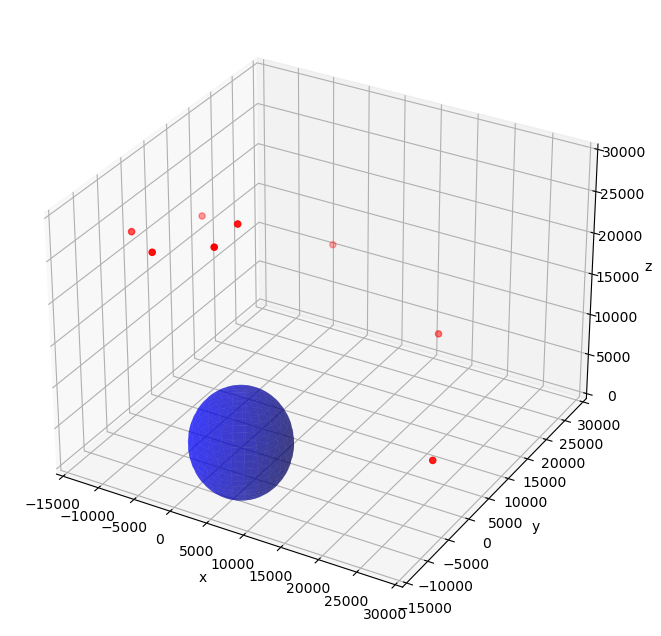

In [48]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_c = 6370 * np.outer(np.cos(u), np.sin(v))
y_c = 6370 * np.outer(np.sin(u), np.sin(v))
z_c = 6370 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_c, y_c, z_c, rstride=4, cstride=4, color='b',alpha=0.5)
A,B,C = Ri[:,0],Ri[:,1],Ri[:,2]
# Plot the satellites
ax.scatter3D(A,B,C,c='r',marker='o')
# set the map area
ax.set_xlim3d(-15000, 30000)
ax.set_ylim3d(-15000,30000)
ax.set_zlim3d(0, 30000)
ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')

plt.show()

## <a name="Section-64">Setting the perturbation of ti</a> [top](#Contents)  

In [49]:
e=1e-8
deltati=[[e,e,e,-e,e,e,e,-e],[e,e,-e,-e,e,e,-e,-e],[e,-e,e,-e,e,-e,e,-e],[e,-e,-e,-e,e,-e,-e,-e]]

In [50]:
deltati

[[1e-08, 1e-08, 1e-08, -1e-08, 1e-08, 1e-08, 1e-08, -1e-08],
 [1e-08, 1e-08, -1e-08, -1e-08, 1e-08, 1e-08, -1e-08, -1e-08],
 [1e-08, -1e-08, 1e-08, -1e-08, 1e-08, -1e-08, 1e-08, -1e-08],
 [1e-08, -1e-08, -1e-08, -1e-08, 1e-08, -1e-08, -1e-08, -1e-08]]

## <a name="Section-65">Solve the problem with Gauss–Newton method</a> [top](#Contents)  

In [67]:
location=[]
for j in range(len(deltati)):
    print(f'pertubation_{j}:{[deltati[j][i] for i in range(8)]}')
    t_intervals=[ti[i]+ deltati[j][i] for i in range(8)]
    #print(t_intervals)
    #print(j)
    #print()
    vector, ite, inf_error,con_res=Gauss_Newton(Ri, t_intervals, [0,0,6370,0.0001], 1e-16, 1000)[0:4]
    error = np.linalg.norm(Gauss_Newton(Ri, t_intervals, [0,0,6370,0.0001], 1e-16, 1000)[-1][-1])
    print(f'result: {con_res}, ite: {ite}')
    print(f'root: {vector}')  
    print(f'|F(x)|: {error}')
    print(f'norm_of_root: {np.linalg.norm(vector[:-1])}') 
    print('------------------------------------------------------')
    location.append(list(vector))

pertubation_0:[1e-08, 1e-08, 1e-08, -1e-08, 1e-08, 1e-08, 1e-08, -1e-08]
result: over maximun iteration, ite: 1001
root: [1.643245350926487e-04 2.607029034129508e-03 6.370004226754636e+03
 1.000148468092609e-04]
|F(x)|: 0.0064318040749443235
norm_of_root: 6370.004226755172
------------------------------------------------------
pertubation_1:[1e-08, 1e-08, -1e-08, -1e-08, 1e-08, 1e-08, -1e-08, -1e-08]
result: cannot iterate anymore, ite: 16
root: [2.1992823084257445e-03 5.7285592168029526e-03 6.3700094612113899e+03
 1.0002202842494061e-04]
|F(x)|: 0.00560611201727373
norm_of_root: 6370.009461214346
------------------------------------------------------
pertubation_2:[1e-08, -1e-08, 1e-08, -1e-08, 1e-08, -1e-08, 1e-08, -1e-08]
result: over maximun iteration, ite: 1001
root: [1.0201956167992857e-03 2.2676758582963604e-03 6.3700042146627520e+03
 1.0000962185145519e-04]
|F(x)|: 0.008035929832866695
norm_of_root: 6370.004214663238
------------------------------------------------------
pertub

In [52]:
deviation=np.array(location)-np.array([0,0,6370,0.0001])
deviation

array([[1.6432453509264869e-04, 2.6070290341295081e-03,
        4.2267546359653352e-03, 1.4846809260899829e-08],
       [2.1992823084257445e-03, 5.7285592168029526e-03,
        9.4612113898620009e-03, 2.2028424940604406e-08],
       [1.0201956167992857e-03, 2.2676758582963604e-03,
        4.2146627520196489e-03, 9.6218514551824237e-09],
       [3.0551531258150213e-03, 5.3892058367653100e-03,
        9.4491188810934545e-03, 1.6803465628997946e-08]])

In [53]:
p_o=[np.linalg.norm(np.array(i[:-1],dtype=float))*1000 for i in deviation]
print(f'the max. position error in meters: {max(p_o)}')

the max. position error in meters: 11.298820637670085


In [54]:
condition_number(deviation,deltati)[0]

3.1559204167377692

In [55]:
# all the emf
condition_number(deviation,deltati)[1]

[1.4098935857703716, 3.1559204167377692, 1.4058601674427877, 3.151886789991713]

__The condition number reduces with more unbunched satellites, helping the accuracy of GPS.__

## <a name="Section-66">The emf of all the combinations of delta ti</a> [top](#Contents)  

In [56]:
comb = list(set(combinations([1e-8]*8+[-1e-8]*8, 8)))

In [57]:
totoal_comb=[] # would have 2^8=256 combinations
for i in comb:
    totoal_comb+=list(set(permutations(i, 8)))

In [58]:
# Solve each combination with Gauss_Newton method
location_all=[]
for j in range(len(totoal_comb)):
    t_intervals=[ti[i]+ totoal_comb[j][i] for i in range(8)]
    vector, ite, inf_error,con_res=Gauss_Newton(Ri, t_intervals, [0,0,6370,0.0001], 1e-16, 1000)[0:4]
    location_all.append(list(vector))

In [59]:
# Calculate the emf of each combination
deviation=np.array(location_all)-np.array([0,0,6370,0.0001])
emfs=condition_number(deviation,totoal_comb)[1]

In [60]:
t1,t2,t3,t4,t5,t6,t7,t8=[],[],[],[],[],[],[],[]
emf=[]
x, y, z, d=[],[],[],[]
for i in range(256):
    t1.append(totoal_comb[i][0])
    t2.append(totoal_comb[i][1])
    t3.append(totoal_comb[i][2])
    t4.append(totoal_comb[i][3])
    t5.append(totoal_comb[i][4])
    t6.append(totoal_comb[i][5])
    t7.append(totoal_comb[i][6])
    t8.append(totoal_comb[i][7])
    x.append(location_all[i][0])
    y.append(location_all[i][1])
    z.append(location_all[i][2])
    d.append(location_all[i][3])
    emf.append(emfs[i])
result=pd.DataFrame(list(zip(t1,t2,t3,t4,t5,t6,t7,t8,x,y,z,d, emf)),
            columns =['delta_t1','delta_t2','delta_t3','delta_t4','delta_t5','delta_t6','delta_t7','delta_t8','x', 'y', 'z', 'd', 'emf'])

In [61]:
result.to_csv('emf_number.csv')

__Sorted by the value of emf__

In [62]:
result.sort_values(by=['emf'])

,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,x,y,z,d,emf
73,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,6.304028e-13,-1.166817e-12,6370.000000,0.0001,3.892083e-10
72,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,2.547318e-12,1.642377e-12,6370.000000,0.0001,1.213499e-09
247,-1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,-8.558713e-04,3.393530e-04,6370.000012,0.0001,2.854879e-01
205,1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,8.558713e-04,-3.393528e-04,6369.999988,0.0001,2.854879e-01
206,1.000000e-08,1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,-9.797467e-04,8.672650e-04,6370.000024,0.0001,3.268083e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,-1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,-5.680248e-03,-4.548607e-03,6369.988246,0.0001,3.920551e+00
36,1.000000e-08,1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,4.824372e-03,4.887956e-03,6370.011766,0.0001,3.924582e+00
147,-1.000000e-08,-1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,-4.824376e-03,-4.887959e-03,6369.988234,0.0001,3.924584e+00
107,1.000000e-08,-1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,6.859549e-03,7.011326e-03,6370.012950,0.0001,4.319681e+00


__The maximum emf of all the combinations__

In [63]:
result[result['emf']==result['emf'].max()]

,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,x,y,z,d,emf
97,-1.000000e-08,1.000000e-08,1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,1.000000e-08,1.000000e-08,-0.00686,-0.007011,6369.98705,0.0001,4.319684


__The minimum emf of all the combinations__

In [64]:
result[result['emf']==result['emf'].min()]

,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,x,y,z,d,emf
73,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,6.304028e-13,-1.166817e-12,6370.0,0.0001,3.892083e-10


__The emf changes per two delta ti combinations. The two combinations with all the opposite signs have a similar emf. When all the delta ti is the same,$(-\epsilon,-\epsilon,-\epsilon,-\epsilon,-\epsilon,-\epsilon,-\epsilon,-\epsilon)$ and $(+\epsilon,+\epsilon,+\epsilon,+\epsilon,+\epsilon,+\epsilon,+\epsilon,+\epsilon) $, the emf are small,3.34E-06. The maximum emf,4.32, is when delta ti are $(-\epsilon,+\epsilon,+\epsilon,-\epsilon,-\epsilon,-\epsilon,+\epsilon,+\epsilon)$ and $(+\epsilon,-\epsilon,-\epsilon,+\epsilon,+\epsilon,+\epsilon,-\epsilon,-\epsilon)$.__

## <a name="Section-7">References</a> [top](#Contents)

* __Plotting the 3D plot: https://github.com/snazrul1/PyRevolution/blob/master/matplotlib/3D%20Plot.ipynb__
* __Permutation and combinations: https://www.geeksforgeeks.org/permutation-and-combination-in-python/__
* __Pandas DataFrame manipulation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html__